In [1]:
# On essaye de réutiliser le code ~/openfisca_france_indirect_taxation/examples/benjello_candidates_to_removal/master_thesis/loosers_within_income_deciles.py
import numpy
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.examples.utils_example import (
    dataframe_by_group,
    graph_builder_bar)
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.projects.budgets.reforme_energie_budgets_2018_2019 import officielle_2019_in_2017
from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy


In [2]:
ident_men = pd.DataFrame(pd.HDFStore("C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data/data_collections/output/openfisca_indirect_taxation_data_2017.h5")['input']['ident_men'])
ident_men['ident_men'] = ident_men.ident_men.astype(numpy.int64)

data_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data"
path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data/donnees_relance_note_mars_2022/fiscalite_indirecte"
elasticite = True
replique_gouv = True

In [3]:
                           
df_elasticities = pd.read_csv(os.path.join(data_path,'Elasticities_literature.csv'), sep = ";")
df_elasticities = df_elasticities.astype({'ref_elasticity': str, 'elas_price_1_1': float , 'elas_price_2_2' : float ,'elas_price_3_3' : float })

# exemple
#elasticites = df_elasticities[df_elasticities['ref_elasticity'] == 'Douenne (2020)'] 

In [34]:
data_year = 2017
# on veut faire les simulations sur les quantités avant réforme
# idéalement on voudrait l'évolution des quantités pour les années jusque 2022 s'il n'y avait pas eu de réforme
# mais en l'absence d'information on considère que la consommation reste constante dans le contrefactuel.
inflators_by_year = get_inflators_by_year_energy(rebuild = True, year_range = range(2011, 2020), data_year = data_year)
inflators_by_year[2018] = inflators_by_year[2017]
inflators_by_year[2019] = inflators_by_year[2017]
inflators_by_year[2020] = inflators_by_year[2017]
inflators_by_year[2021] = inflators_by_year[2017]
inflators_by_year[2022] = inflators_by_year[2017]
year = 2019

c:\Users\veve1\OneDrive\Documents\ENSAE 3A\Memoire MiE\hervenv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [11]:
# elasticités : le programme de T. Douenne n'a pas été bien adapté (pas le temps) et du coup on a pas d'élasticité pour tout le monde
# on prend des élasticités agrégées par type de bien

ident_men['elas_price_1_1'] = elasticites['elas_price_1_1'].reset_index()['elas_price_1_1'][0] # transport fuel
ident_men['elas_price_2_2'] = elasticites['elas_price_2_2'].reset_index()['elas_price_2_2'][0] # housing fuel
ident_men['elas_price_3_3'] = elasticites['elas_price_3_3'].reset_index()['elas_price_3_3'][0] # other non durable goods ??

elasticities = ident_men
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

NameError: name 'elasticites' is not defined

In [12]:
simulated_variables = [
        'total_taxes_energies',
        'total_taxes_energies_officielle_2019_in_2017',
        'ticgn',
        'ticgn_officielle_2019_in_2017',
        'cheques_energie',
        'rev_disp_loyerimput',
        'pondmen',
        'ocde10',
        'niveau_vie_decile'
        ]

In [13]:
baseline_tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
asof(baseline_tax_benefit_system, "2017-12-31")
if elasticite:
    survey_scenario = SurveyScenario.create(
        elasticities = elasticities,
        inflation_kwargs = inflation_kwargs,
        baseline_tax_benefit_system = baseline_tax_benefit_system,
        reform = officielle_2019_in_2017,
        year = year,
        data_year = data_year
        )
else:
    survey_scenario = SurveyScenario.create( 
        inflation_kwargs = inflation_kwargs,
        baseline_tax_benefit_system = baseline_tax_benefit_system,
        reform = officielle_2019_in_2017,
        year = year,
        data_year = data_year
        )

KeyboardInterrupt: 

In [39]:
indiv_df_reform = survey_scenario.create_data_frame_by_entity(simulated_variables, period = year)
#indiv_df_reference = survey_scenario.create_data_frame_by_entity(simulated_variables, use_baseline =True, period = year)

menages_reform= indiv_df_reform['menage']
#menages_reference_test = indiv_df_reference['menage']


In [15]:
menages_reform['Net_apres_cheques_energie'] = menages_reform['cheques_energie'] - \
    (menages_reform['total_taxes_energies_officielle_2019_in_2017'] - menages_reform['total_taxes_energies']) - \
        (menages_reform['ticgn_officielle_2019_in_2017'] - menages_reform['ticgn'])
        

In [16]:
menages_reform['is_losers'] = menages_reform['Net_apres_cheques_energie'] <0 
grouped_df = menages_reform.groupby('niveau_vie_decile')
losers_df = menages_reform[menages_reform['is_losers'] == True]
grouped_losers = losers_df.groupby('niveau_vie_decile')

In [17]:
share_decile = grouped_losers['pondmen'].sum() / grouped_df['pondmen'].sum() * 100
share_total = grouped_losers['pondmen'].sum().sum() / grouped_df['pondmen'].sum().sum() *100

In [18]:
to_graph = pd.DataFrame(share_decile)
to_graph.reset_index(inplace = True)
to_graph = pd.concat([to_graph,pd.DataFrame(data = {'niveau_vie_decile' : 'Total', 'pondmen' : share_total}, index = [0])])

to_graph.rename(columns = {'pondmen' : 'losers'}, inplace = True)
to_graph['winners'] = 100 - to_graph['losers']
#ref_elasticity = elasticites['ref_elasticity'].reset_index()['ref_elasticity'][0]
#to_graph['ref_elasticity'] = ref_elasticity

In [4]:
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Simulation_taxe_energie_winners_losers import (
    simulate_reformes_energie,
    run_all_elasticities
    )

In [5]:
to_graph, menages_reform = run_all_elasticities(df_elasticities)

c:\Users\veve1\OneDrive\Documents\ENSAE 3A\Memoire MiE\hervenv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
plt.figure(figsize= (10,7.5)) 
# Si on veut avoir la part de gagnants qui complète la bar jusqu'à 1 
#to_graph['total'] = 1
#bar1 = sns.barplot(x="niveau_vie_decile", y = 'total', data = to_graph, hue = 'ref_elasticity', palette = sns.color_palette("muted"), saturation = .2, width=.9)
bar2 = sns.barplot(x="niveau_vie_decile", y = 'losers', data = to_graph, hue = 'ref_elasticity', palette = sns.color_palette("Paired"), width = .9)
plt.xlabel('Revenu decile', fontdict = {'fontsize' : 12})
plt.ylabel('Share of net losers from the reform', fontdict = {'fontsize' : 12})
plt.legend()
plt.savefig(os.path.join(path,'Winners_losers_reform.png'))

<Axes: xlabel='niveau_vie_decile', ylabel='Net_apres_cheques_energie'>

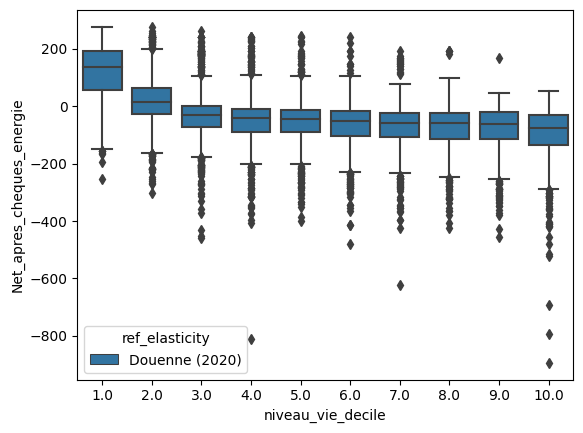

In [45]:
sns.boxplot(data = menages_reform, x = "niveau_vie_decile", y = "Net_apres_cheques_energie", hue = "ref_elasticity")

In [44]:
menages_reform['ref_elasticity'] = 'Douenne (2020)'

In [57]:
menages_reform['taux_effort'] = menages_reform['total_taxes_energies_officielle_2019_in_2017'] / menages_reform['rev_disp_loyerimput'] * 100

<Axes: xlabel='niveau_vie_decile', ylabel='taux_effort'>

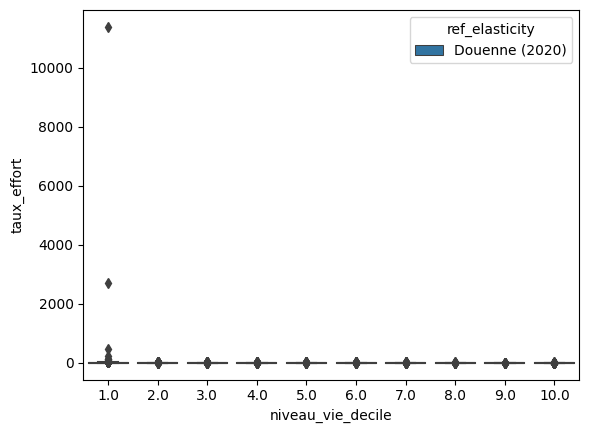

In [59]:
sns.boxplot(data = menages_reform, x = "niveau_vie_decile", y = "taux_effort", hue = "ref_elasticity")

In [53]:
menages_reform.columns

Index(['ocde10', 'cheques_energie', 'ticgn_officielle_2019_in_2017',
       'total_taxes_energies', 'ticgn', 'rev_disp_loyerimput', 'pondmen',
       'niveau_vie_decile', 'total_taxes_energies_officielle_2019_in_2017',
       'Net_apres_cheques_energie', 'is_losers', 'ref_elasticity',
       'taux_effort'],
      dtype='object')

In [62]:
menages_reform.sort_values(by = 'taux_effort', ascending= False)

,ocde10,cheques_energie,ticgn_officielle_2019_in_2017,total_taxes_energies,ticgn,rev_disp_loyerimput,pondmen,niveau_vie_decile,total_taxes_energies_officielle_2019_in_2017,Net_apres_cheques_energie,is_losers,ref_elasticity,taux_effort
10137,1.0,194.0,0.000000,867.485291,0.000000,0.000000,3180,1.0,941.055908,120.429382,False,Douenne (2020),inf
6656,2.1,277.0,0.000000,1060.844727,0.000000,0.000000,2073,1.0,1177.362793,160.481934,False,Douenne (2020),inf
845,1.0,194.0,35.860615,507.214661,24.988861,0.000000,2632,1.0,524.879578,165.463333,False,Douenne (2020),inf
7583,1.0,194.0,0.000000,242.398499,0.000000,0.000000,6455,1.0,262.956055,173.442444,False,Douenne (2020),inf
4603,1.0,194.0,0.000000,198.233994,0.000000,0.000000,4467,1.0,205.137939,187.096054,False,Douenne (2020),inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4908,1.5,0.0,161.798584,0.000000,112.814163,39712.878906,2669,5.0,0.000000,-48.984421,True,Douenne (2020),0.0
8795,1.5,0.0,301.480652,0.000000,210.207565,60138.906250,2230,9.0,0.000000,-91.273087,True,Douenne (2020),0.0
8796,1.3,0.0,0.000000,0.000000,0.000000,32556.853516,450,5.0,0.000000,0.000000,False,Douenne (2020),0.0
8987,1.5,0.0,0.000000,0.000000,0.000000,34242.246094,2065,5.0,0.000000,0.000000,False,Douenne (2020),0.0
